In [1]:
import unicodedata
import os
import glob
import string
from unidecode import unidecode
import torch
import random
import torch.nn as nn
from rnn import RNN
%load_ext autoreload

%autoreload 2

In [2]:
DATA_PATH = "names"

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


In [3]:
#funny thing that unicodedata.normalize("NFD", "Ł") doesn't work
# def unicodeToAscii(string):
#     return unidecode(string)

def readNames(filename):
    with open(filename,"r", encoding="utf-8") as f:
        names = f.read().strip().split("\n")
        return [unidecode(n) for n in names]


def getNamesData():
    data = {}
    for f in glob.glob(f"{DATA_PATH}/*.txt"):
        country = os.path.splitext(os.path.basename(f))[0] # this is more explicit than writing split("")[-1]
        data[country] = readNames(f)
    
    return data
    
NAMES = getNamesData()
ALL_COUNTRIES = list(NAMES.keys())
#with open(os.path.join(DATA_PATH, "Polish.txt"), "r") as f:
#    print(f.read())

#print(readNames(os.path.join(DATA_PATH, "Polish.txt"))[-1])
#print(glob.glob("names/*.txt"))


In [4]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1

    return tensor

#print(letterToTensor("M"))
#print(lineToTensor("Maciek"))

In [5]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # returning best k outputs
    top_country = top_i[0].item()
    return ALL_COUNTRIES[top_country], top_country

In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(countries, data):
    country = randomChoice(countries)
    line = randomChoice(data[country])
    country_tensor = torch.tensor([countries.index(country)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return country, line, country_tensor, line_tensor

for i in range(10):
    country, line, country_tensor, line_tensor = randomTrainingExample(ALL_COUNTRIES, NAMES)
    print('country =', country, '/ line =', line)

country = Spanish / line = Ortiz
country = Russian / line = Haschenko
country = Korean / line = Ma
country = Irish / line = Eoin
country = Chinese / line = Yep
country = French / line = Bouchard
country = German / line = Lowe
country = Japanese / line = Tsuda
country = Scottish / line = Morrison
country = Irish / line = O'Donoghue


In [7]:
criterion = nn.NLLLoss()
lr = 0.005
rnn = RNN(n_letters, 128, len(ALL_COUNTRIES))

In [8]:
#for p in rnn.parameters():
    #print(p)

In [9]:
def train(country_tensor, line_tensor, criterion):
    #This trains for just a single example
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, country_tensor)
    loss.backward()

    #We are not using any optimizer
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()
        

In [10]:
n_iters = 100000
print_every = 5000
#plot_every = 1000

current_loss = 0 
all_losses = []

for i in range(1, n_iters + 1):
    country, line, country_tensor, line_tensor = randomTrainingExample(ALL_COUNTRIES, NAMES)
    output, loss = train(country_tensor, line_tensor, criterion)

    current_loss += loss

    if i % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        print(f"iteration {i}, loss: {current_loss / print_every}")
        print(f"Guessed: {guess}, answer: {country}, line: {line}")

        all_losses.append(current_loss / print_every)
        current_loss = 0
        
        


iteration 5000, loss: 2.7874184567451477
Guessed: Vietnamese, answer: Russian, line: Pazy
iteration 10000, loss: 2.2457043774932623
Guessed: Arabic, answer: Russian, line: Bass
iteration 15000, loss: 1.919575013963878
Guessed: Portuguese, answer: Portuguese, line: Mateus
iteration 20000, loss: 1.726700738329813
Guessed: Italian, answer: Italian, line: Brivio
iteration 25000, loss: 1.6321668366303668
Guessed: Czech, answer: Polish, line: Stanek
iteration 30000, loss: 1.5239602475030347
Guessed: Korean, answer: Korean, line: Oh 
iteration 35000, loss: 1.507844653147459
Guessed: Portuguese, answer: Greek, line: Demas
iteration 40000, loss: 1.437562377931364
Guessed: Portuguese, answer: Czech, line: Merta
iteration 45000, loss: 1.3906025830023456
Guessed: Polish, answer: Polish, line: Winograd
iteration 50000, loss: 1.3511015684338519
Guessed: French, answer: Dutch, line: Rumpade
iteration 55000, loss: 1.3371195090061985
Guessed: Korean, answer: Korean, line: Yi
iteration 60000, loss: 1.29

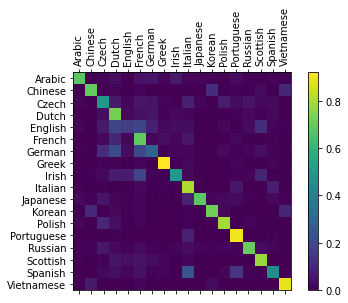

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

confusion = torch.zeros(len(ALL_COUNTRIES), len(ALL_COUNTRIES))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(ALL_COUNTRIES, NAMES)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = ALL_COUNTRIES.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(ALL_COUNTRIES)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + ALL_COUNTRIES, rotation=90)
ax.set_yticklabels([''] + ALL_COUNTRIES)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()